<a href="https://colab.research.google.com/github/Waye/CSC420-CourseWork-fall2019/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### preprocesing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

# install OpenCV
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
!pip install torch
!pip install torchvision
!pip install pandas
!pip install scikit-multilearn
!pip install kornia

import kornia
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 25.0MB 55.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 1.8MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18
     |████████████████████████████████| 92kB 5.3MB/s 
     |████████████████████████████████| 122kB 6.9MB/s 


#Download datasets

Datasets are uploaded to GitLab and pulled to Colab. Note that only subset (1000 train data and 1000 test data) of the zipped dataset is extracted and uploaded. This is because the whole dataset is ~6GB and loading to Colab would take a long time. Therefore we decided to use data augmentation technique to expand the size of the dataset.

Since ImageFolder will look for the sub-directory structure and assign the labels according to the sub-directory name, for example all images under the sub-directory `train/0/*.tif` would have label 0, manually move all of the images to the corresponding sub-subdirectory by looking up label value in `train_lables.csv`.

In [5]:
# Only download dataset when not present in drive
%%bash
if [ ! -d '/content/drive/My Drive/Colab Notebooks/project/dataset' ]; then
  set -x
  mkdir -p '/content/drive/My Drive/Colab Notebooks/project/dataset'
  cd '/content/drive/My Drive/Colab Notebooks/project/dataset'
  git clone https://gitlab.com/zonggen/histopathologic-cancer-dataset.git
  set +x
else
  echo "Dataset already downloaded in '/content/drive/My Drive/Colab Notebooks/project/dataset'"
fi

if [ ! -d ./train/0 ]; then
  mkdir -p ./train/0
fi

if [ ! -d ./test/0 ]; then
  mkdir -p ./test/0
fi

Dataset already downloaded in '/content/drive/My Drive/Colab Notebooks/project/dataset'


# Transformation
Apply transformations to augment the dataset before training the model. The following transformations are applied to discuss the effect of random transformation on the training of a CNN model:
 - Random rotation
 - Random flip
 - Random crop
 - Change of brightness, contrast and saturation

In [6]:
%cd '/content/drive/My Drive/Colab Notebooks/project/dataset/histopathologic-cancer-dataset'

import torch
from torchvision import datasets, transforms

path = '/content/drive/My Drive/Colab Notebooks/project/dataset/histopathologic-cancer-dataset/'
testfolder = path+'test'
trainfolder = path+'train'

# Transformation with only center crop 32x32
transform_original = transforms.Compose([transforms.CenterCrop(32),
                                transforms.ToTensor()])
# List of random transformations for data augmentation
transform_rotation = transforms.Compose([transforms.CenterCrop(32),
                                transforms.RandomRotation(180),
                                transforms.ToTensor()])
transform_flip = transforms.Compose([transforms.CenterCrop(32),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor()])
transform_affine = transforms.Compose([transforms.CenterCrop(32),
                                transforms.RandomAffine(180),
                                transforms.ToTensor()])
transform_random_crop = transforms.Compose([transforms.RandomCrop(32),
                                transforms.ToTensor()])
transform_colorjitter = transforms.Compose([transforms.CenterCrop(32),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])

/content/drive/My Drive/Colab Notebooks/project/dataset/histopathologic-cancer-dataset


# Image sorting
Read the CSV file and sort the image files according to their id from the CSV file.

In [7]:
import os

path = '/content/drive/My Drive/Colab Notebooks/project/dataset/histopathologic-cancer-dataset/'
testfolder = path+'test'
trainfolder = path+'train'

# Read the training csv file and load the {id:label} to a dictionary
train_labels = "/content/drive/My Drive/Colab Notebooks/project/dataset/histopathologic-cancer-dataset/train_labels.csv"
df = pd.read_csv(train_labels)
train_labels = {k:v for k,v in zip(df.id.values, df.label.values)}
print(df.head())

for filename in os.listdir(trainfolder+'/1'):
  image_id = filename.split('.')[0]
  if train_labels[image_id] == 0:
    os.replace(trainfolder+'/1/'+image_id+'.tif', trainfolder+'/0/'+image_id+'.tif')

# Read the sample submission csv file and load the {id:label} to a dictionary
test_labels = "/content/drive/My Drive/Colab Notebooks/project/dataset/histopathologic-cancer-dataset/sample_submission.csv"
df_test = pd.read_csv(test_labels)
test_labels = {k:v for k,v in zip(df_test.id.values, df_test.label.values)}
print(df_test.head())

for filename in os.listdir(testfolder+'/1'):
  image_id = filename.split('.')[0]
  if test_labels[image_id] == 0:
    os.replace(testfolder+'/1/'+image_id+'.tif', testfolder+'/0/'+image_id+'.tif')

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0


# Build CNN model 
[Reference](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/)

In [0]:
# Link to original tutorial: https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np

# Hyperparameters
num_epochs = 8 #fully run 8 iteration for full dataset
num_classes = 2 #need 2 outputs 0,1
batch_size = 64
learning_rate = 0.001 #a tuning parameter 
#in an optimization algorithm that determines 
#the step size at each iteration while moving toward a minimum of a loss function.


# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            # 3 groups RGB inputs each with 32 channel so totally, 
            # 3*32=96 channel, conv kenal 5x5
            # image size 32*32
            nn.Conv2d(3, 96, (5,5), stride=1, padding=2, groups=3),
            # ReLU is the most commonly used activation function in neural networks
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            # shrink to size 16*16 # of channels increase by 1.
            nn.Conv2d(96, 192, (5,5), stride=1, padding=2, groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 384, (5,5), stride=1, padding=2, groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 768, (5,5), stride=1, padding=2, groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        # flat into linear blocks
        self.fc1 = nn.Linear(2 * 2 * 768, 1000)
        #  2 outputs
        self.fc2 = nn.Linear(1000 , 2)
       

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        # drop-out layer to avoid over-fitting in the model
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Loss and optimizer
criterion = nn.CrossEntropyLoss()

def optimizer(model):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  return optimizer

loss_list = []
acc_list = []
# Train the model
def train_model(trainset,trainloader,model,LoG=False):
  total_step = len(trainset)
  for epoch in range(num_epochs):
      
      for i, (images, labels) in enumerate(trainloader):
          
          # Apply laplacian of gaussian for comparison
          if (LoG):
            images = kornia.filters.gaussian_blur2d(images, (3, 3), (1.5, 1.5))
            images = kornia.filters.laplacian(images,3)
          
          # forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss_list.append(loss.item())

          # optimization in backpropgation
          optimizer(model).zero_grad()
          loss.backward()
          optimizer(model).step()

          # output acccuracy after each epoch
          total = labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          acc_list.append(correct / total)

          if (i + 1) % 16 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),(correct / total) * 100))

# Test the model
def test_model(test_model,testloader_new):
  test_model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in testloader_new:
          outputs = test_model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the '+ str(total) +' test images: {} %'.format((correct / total) * 100) + '\n')

# Save the model 
def save_model(model):
  torch.save(model.state_dict(), path + 'conv_net_model.ckpt')

# Test transformation effect on Accuracy

In [11]:
transform_original = transforms.Compose([transforms.CenterCrop(32),
                                transforms.ToTensor()])
transform_rotation = transforms.Compose([transforms.CenterCrop(32),
                                transforms.RandomRotation(180),
                                transforms.ToTensor()])
transform_flip = transforms.Compose([transforms.CenterCrop(32),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor()])
transform_affine = transforms.Compose([transforms.CenterCrop(32),
                                transforms.RandomAffine(180),
                                transforms.ToTensor()])

# transform oringinal
print("transform oringinal")
trainset_ori = datasets.ImageFolder(trainfolder, transform=transform_original)
trainloader_ori = torch.utils.data.DataLoader(trainset_ori, batch_size=64, shuffle=True)
testset_ori = datasets.ImageFolder(testfolder, transform=transform_original)
testloader_ori = torch.utils.data.DataLoader(testset_ori, batch_size=64, shuffle=False)
model_ori=ConvNet()

train_model(trainset_ori,trainloader_ori,model_ori)
test_model(model_ori,testloader_ori)

# transform_rotation 
print("transform rotation")
trainset_rot = datasets.ImageFolder(trainfolder, transform=transform_rotation)
trainloader_rot = torch.utils.data.DataLoader(trainset_rot, batch_size=64, shuffle=True)
testset_rot = datasets.ImageFolder(testfolder, transform=transform_rotation)
testloader_rot = torch.utils.data.DataLoader(testset_rot, batch_size=64, shuffle=False)
model_rot=ConvNet()

train_model(trainset_rot,trainloader_rot,model_rot)
test_model(model_rot,testloader_rot)

# transform_flip 
print("transform flip")
trainset_flip = datasets.ImageFolder(trainfolder, transform=transform_flip)
trainloader_flip= torch.utils.data.DataLoader(trainset_flip, batch_size=64, shuffle=True)
testset_flip = datasets.ImageFolder(testfolder, transform=transform_flip)
testloader_flip = torch.utils.data.DataLoader(testset_flip, batch_size=64, shuffle=False)
model_flip=ConvNet()

train_model(trainset_flip,trainloader_flip,model_flip)
test_model(model_flip,testloader_flip)

# transform_affine 
print("transform affine")
trainset_aff = datasets.ImageFolder(trainfolder, transform=transform_affine)
trainloader_aff= torch.utils.data.DataLoader(trainset_aff, batch_size=64, shuffle=True)
testset_aff = datasets.ImageFolder(testfolder, transform=transform_affine)
testloader_aff = torch.utils.data.DataLoader(testset_aff, batch_size=64, shuffle=False)
model_aff=ConvNet()

train_model(trainset_aff,trainloader_aff,model_aff)
test_model(model_aff,testloader_aff)

# Do the same but with laplacian of gaussian filter
# transform oringinal
print("LoG - transform oringinal")
train_model(trainset_ori,trainloader_ori,model_ori, True)
test_model(model_ori,testloader_ori)

# transform_rotation 
print("LoG - transform rotation")
train_model(trainset_rot,trainloader_rot,model_rot, True)
test_model(model_rot,testloader_rot)

# transform_flip 
print("LoG - transform flip")
train_model(trainset_flip,trainloader_flip,model_flip, True)
test_model(model_flip,testloader_flip)

# transform_affine 
print("LoG - transform affine")
train_model(trainset_aff,trainloader_aff,model_aff, True)
test_model(model_aff,testloader_aff)

transform oringinal
Epoch [1/8], Step [16/1000], Loss: 0.6123, Accuracy: 75.00%
Epoch [2/8], Step [16/1000], Loss: 0.6684, Accuracy: 65.00%
Epoch [3/8], Step [16/1000], Loss: 0.6253, Accuracy: 70.00%
Epoch [4/8], Step [16/1000], Loss: 0.6175, Accuracy: 70.00%
Epoch [5/8], Step [16/1000], Loss: 0.6746, Accuracy: 60.00%
Epoch [6/8], Step [16/1000], Loss: 0.8727, Accuracy: 60.00%
Epoch [7/8], Step [16/1000], Loss: 0.5217, Accuracy: 70.00%
Epoch [8/8], Step [16/1000], Loss: 0.4686, Accuracy: 75.00%
Test Accuracy of the model on the 1000 test images: 99.1 %

transform rotation
Epoch [1/8], Step [16/1000], Loss: 0.6796, Accuracy: 57.50%
Epoch [2/8], Step [16/1000], Loss: 0.6693, Accuracy: 65.00%
Epoch [3/8], Step [16/1000], Loss: 0.6090, Accuracy: 70.00%
Epoch [4/8], Step [16/1000], Loss: 0.7050, Accuracy: 62.50%
Epoch [5/8], Step [16/1000], Loss: 0.6281, Accuracy: 72.50%
Epoch [6/8], Step [16/1000], Loss: 0.5861, Accuracy: 75.00%
Epoch [7/8], Step [16/1000], Loss: 1.2629, Accuracy: 22.50%
E

In [12]:
!nvidia-smi


Wed Dec  4 06:32:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Test loading model run sample test

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
import numpy as np

#save oringinal transformation model
save_model(model_ori) 

# load model 
load_model = ConvNet()
load_model.load_state_dict(torch.load(path + 'conv_net_model.ckpt'))

# return predicetd label index [0,1], when index[0]="0",index[1]="1"
# where "0" represents no tumor cells present and "1" meaning tumor cells
# are detected
for images, labels in testloader_ori:
  outputs = load_model(images)
  predicted = torch.max(outputs.data, 1)# return value of axis 1
  print(predicted.indices)




tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

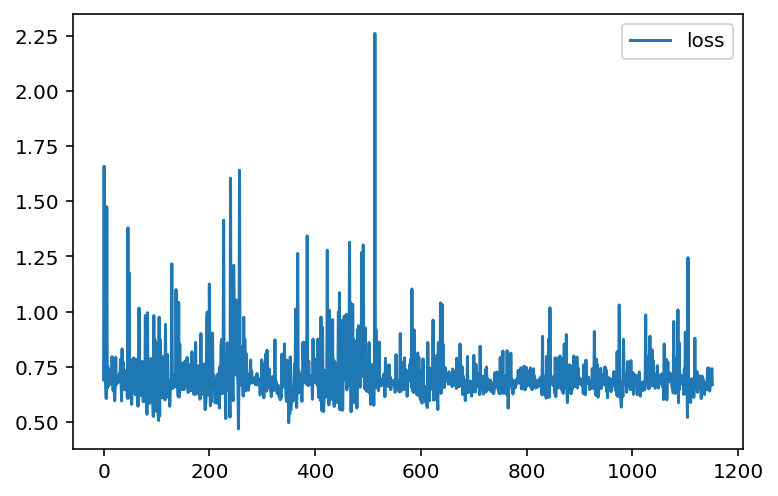

In [14]:
import numpy as np 
plt.plot(np.array(loss_list) ,label='loss')
plt.legend(frameon=show)
plt.show()


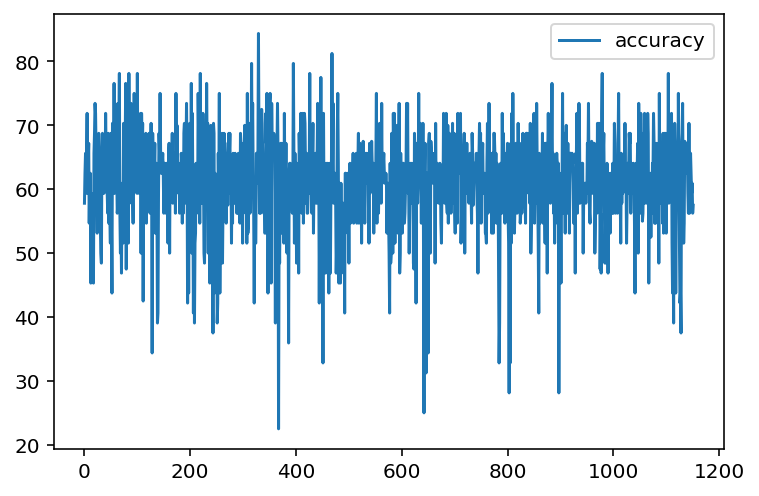

In [15]:
plt.plot(np.array(acc_list)*100 , label='accuracy')
plt.legend(frameon=show)
plt.show()